In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import tensor_builder as tb

import Metrica_IO as mio
import Metrica_Velocities as mvel

from soccermap_model import SoccerMap
from sklearn.model_selection import train_test_split

In [2]:
DATADIR = './data'
game_id = 2 # sample match 2

events = mio.read_event_data(DATADIR,game_id)
events.head(5)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [3]:
# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

tracking_home

Reading team: home
Reading team: away


,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.000000,-0.008179,0.111964,0.112263,-0.009964,0.091464,0.092005,-0.010571,0.145964,0.146347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,5646.08,0.93715,0.48757,0.61501,0.84644,0.77442,0.58645,0.72858,0.67791,...,0.014590,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.013000,-0.019071,0.023081
141153,2,5646.12,0.93715,0.48757,0.61501,0.84644,0.77442,0.58645,0.72858,0.67791,...,0.011924,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.014571,-0.014429,0.020506
141154,2,5646.16,0.93715,0.48757,0.61501,0.84644,0.77442,0.58645,0.72858,0.67791,...,0.011087,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.014464,-0.014411,0.020418


In [4]:
# Assuming 3 subs, may need to change
home_player_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
away_player_ids = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26]

# Clip positions to be within 0 and 1
for pid in home_player_ids:
    tracking_home[f'Home_{pid}_x'] = tracking_home[f'Home_{pid}_x'].clip(lower=0, upper=1)
    tracking_home[f'Home_{pid}_y'] = tracking_home[f'Home_{pid}_y'].clip(lower=0, upper=1)

for pid in away_player_ids:
    tracking_away[f'Away_{pid}_x'] = tracking_away[f'Away_{pid}_x'].clip(lower=0, upper=1)
    tracking_away[f'Away_{pid}_y'] = tracking_away[f'Away_{pid}_y'].clip(lower=0, upper=1)

In [5]:
# Scale positions to actual field dimensions
field_size = (104,68)  

# Scale home team positions
for pid in home_player_ids:
    tracking_home[f'Home_{pid}_x'] *= field_size[0]
    tracking_home[f'Home_{pid}_y'] *= field_size[1]

# Scale away team positions
for pid in away_player_ids:
    tracking_away[f'Away_{pid}_x'] *= field_size[0]
    tracking_away[f'Away_{pid}_y'] *= field_size[1]

In [6]:
# Determine successful action based on 'BALL LOST' event
events['Success'] = 1
ball_lost_indices = events[events['Type'] == 'BALL LOST'].index

for idx in ball_lost_indices:
    if idx > 0 and events.loc[idx - 1, 'Type'] == 'PASS':
        events.loc[idx - 1, 'Success'] = 0

In [7]:
pass_events = events[events['Type'] == 'PASS']
ball_drive_events = events[events['Type'] == 'BALL DRIVE']
shot_events = events[events['Type'] == 'SHOT']

# Pass success percentage in dataset  
pass_success = pass_events[pass_events['Success'] == 1]
persuc = len(pass_success) / len(pass_events)
print(persuc)

0.8993775933609959


In [8]:
tensors = []
labels = []
outcomes = []

# For graphing later
start_positions = []

# Iterate over each event and process it
for index, row in pass_events.iterrows():
    event_time = row['Start Time [s]']
    focus_team = row['Team']
    tracking_home_snap = tb.find_closest_tracking_snapshot(event_time, tracking_home)
    tracking_away_snap = tb.find_closest_tracking_snapshot(event_time, tracking_away)

    # Build the game representation tensor, target label, and outcome
    if focus_team == "Home":
        tensor, target, outcome = tb.build_representation(row, tracking_home_snap, tracking_away_snap)
        tensors.append(tensor)
        labels.append(target)  # Append the (endx, endy) coordinates as label
        outcomes.append(outcome)  # Append the pass success outcome (0 or 1)
        start_positions.append([row['Start X'], row['Start Y']])


tensors = torch.cat(tensors, dim=0)  # (N, 13, 104, 68) 
labels = torch.tensor(labels)  # (N, 2)
outcomes = torch.tensor(outcomes, dtype=torch.float32)  # (N,)
start_positions = torch.tensor(start_positions) # For graphing only

In [9]:
train_events, temp_events, train_labels, temp_labels, train_outcomes, temp_outcomes, train_starts, temp_starts = train_test_split(
    tensors, labels, outcomes, start_positions, test_size=0.4, random_state=42, shuffle=True
)

validation_events, test_events, validation_labels, test_labels, validation_outcomes, test_outcomes, validation_starts, test_starts = train_test_split(
    temp_events, temp_labels, temp_outcomes, temp_starts, test_size=0.5, random_state=42, shuffle=True
)

print("Training Set:", train_events.shape)
print("Validation Set:", validation_events.shape)
print("Test Set:", test_events.shape)

Training Set: torch.Size([325, 13, 104, 68])
Validation Set: torch.Size([109, 13, 104, 68])
Test Set: torch.Size([109, 13, 104, 68])


In [22]:
from train import train_model

from soccermap_dcn_split import SoccerMapDCNMixed
#from soccermap_dcn_nosplit import SoccerMapDCNMixed

model = SoccerMapDCNMixed(in_channels=13)
train_model(model, train_events, train_labels, train_outcomes, num_epochs=10, batch_size=32, lr=1e-4, name='Test_FinalDCN_NoSplit')

KeyboardInterrupt: 

In [23]:
# For testing
model = SoccerMapDCNMixed(in_channels=13)
model.load_state_dict(torch.load('./models/Test_FinalDCN_Split'))

C:\Users\Andre\AppData\Local\Temp\ipykernel_20764\2092285061.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/Test_FinalDCN_Spl

<All keys matched successfully>

In [24]:
from validate import evaluate_model

criterion = nn.BCELoss()

val_dataset = TensorDataset(validation_events, torch.tensor(validation_labels), validation_outcomes)
test_dataset = TensorDataset(test_events, torch.tensor(test_labels), test_outcomes)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

C:\Users\Andre\AppData\Local\Temp\ipykernel_20764\2772355083.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(validation_events, torch.tensor(validation_labels), validation_outcomes)
C:\Users\Andre\AppData\Local\Temp\ipykernel_20764\2772355083.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(test_events, torch.tensor(test_labels), test_outcomes)


Validation Loss: 0.3522, Validation Accuracy: 0.9083
Test Loss: 0.4318, Test Accuracy: 0.8899


In [11]:
# Select a random sample from test_events
random_sample = test_events[34] 
ballx, bally = test_starts[34]
ballx = ballx * 104
bally = bally * 68

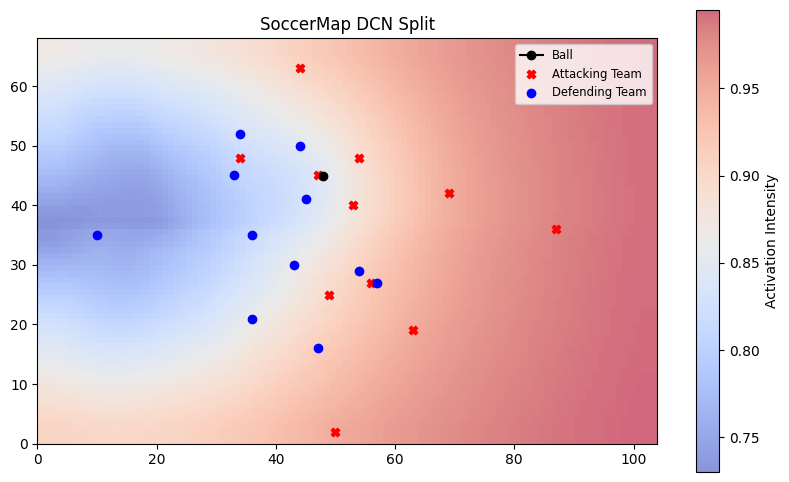

In [25]:
from plot import plot_output

ball_position= (ballx, bally)
plot_output(model, random_sample, ball_position, title='SoccerMap DCN Split')

In [ ]:
import numpy as np
model.eval()  

with torch.no_grad():
    output = model(random_sample.unsqueeze(0))
    output_squeezed = np.squeeze(output).detach().numpy()  # Convert to numpy array for plotting

print(output_squeezed)